In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
import os

from common import h5dataset, onnxexporter, model_dnn, trainer


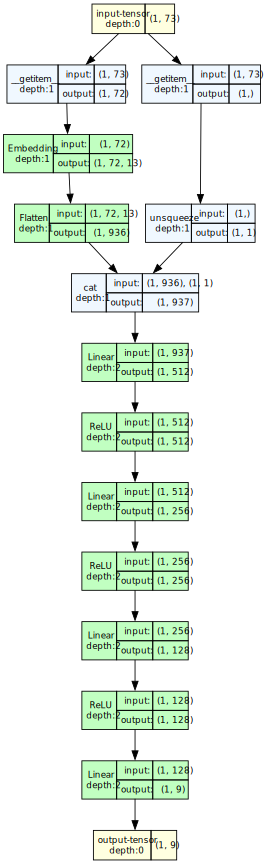

In [2]:
# Plot model graph
model = model_dnn.ModelDNNWithScore(
    name="JassPlayWithScore",
    input_size=73,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 73).long(), show_shapes=True)
model_graph.visual_graph

In [3]:
DATASET_PATH = '../log_parser/dataset/flat_playing_with_score.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/play_with_score'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play_with_score'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [4]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()
loss_fn = lambda y_pred, y_true: F.nll_loss(F.log_softmax(y_pred, dim=1), y_true)

# set up trainer
trainer = trainer.Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [5]:
# train the model
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer.train(NUM_EPOCHS, model, optimizer)

Training model: JassPlayWithScore_512_256_128_dnn


Validation Epoch 1: 100%|██████████| 17333/17333 [01:08<00:00, 252.97it/s]


Epoch 1/20 - Train Loss: 0.8001, Train Accuracy: 66.3387, Val Loss: 0.7290, Val Accuracy: 69.4792
Model saved at epoch 1 with validation loss 0.7290


Validation Epoch 2: 100%|██████████| 17333/17333 [01:07<00:00, 258.21it/s]


Epoch 2/20 - Train Loss: 0.7013, Train Accuracy: 70.7510, Val Loss: 0.6803, Val Accuracy: 71.7331
Model saved at epoch 2 with validation loss 0.6803


Validation Epoch 3: 100%|██████████| 17333/17333 [01:07<00:00, 255.38it/s]


Epoch 3/20 - Train Loss: 0.6723, Train Accuracy: 72.1425, Val Loss: 0.6597, Val Accuracy: 72.6956
Model saved at epoch 3 with validation loss 0.6597


Validation Epoch 4: 100%|██████████| 17333/17333 [01:09<00:00, 248.94it/s]


Epoch 4/20 - Train Loss: 0.6569, Train Accuracy: 72.8922, Val Loss: 0.6529, Val Accuracy: 73.1024
Model saved at epoch 4 with validation loss 0.6529


Validation Epoch 5: 100%|██████████| 17333/17333 [01:08<00:00, 252.39it/s]


Epoch 5/20 - Train Loss: 0.6475, Train Accuracy: 73.3844, Val Loss: 0.6418, Val Accuracy: 73.7072
Model saved at epoch 5 with validation loss 0.6418


Validation Epoch 6: 100%|██████████| 17333/17333 [01:08<00:00, 252.11it/s]


Epoch 6/20 - Train Loss: 0.6413, Train Accuracy: 73.7330, Val Loss: 0.6370, Val Accuracy: 73.9748
Model saved at epoch 6 with validation loss 0.6370


Validation Epoch 7: 100%|██████████| 17333/17333 [01:09<00:00, 250.62it/s]


Epoch 7/20 - Train Loss: 0.6366, Train Accuracy: 74.0154, Val Loss: 0.6381, Val Accuracy: 73.9791


Validation Epoch 8: 100%|██████████| 17333/17333 [01:08<00:00, 254.62it/s]


Epoch 8/20 - Train Loss: 0.6319, Train Accuracy: 74.2416, Val Loss: 0.6308, Val Accuracy: 74.1573
Model saved at epoch 8 with validation loss 0.6308


Validation Epoch 9: 100%|██████████| 17333/17333 [01:09<00:00, 248.62it/s]


Epoch 9/20 - Train Loss: 0.6283, Train Accuracy: 74.4171, Val Loss: 0.6324, Val Accuracy: 74.1667


Validation Epoch 10: 100%|██████████| 17333/17333 [01:07<00:00, 254.99it/s]


Epoch 10/20 - Train Loss: 0.6257, Train Accuracy: 74.5573, Val Loss: 0.6252, Val Accuracy: 74.6027
Model saved at epoch 10 with validation loss 0.6252


Validation Epoch 11: 100%|██████████| 17333/17333 [01:08<00:00, 253.29it/s]


Epoch 11/20 - Train Loss: 0.6238, Train Accuracy: 74.6532, Val Loss: 0.6272, Val Accuracy: 74.4423


Validation Epoch 12: 100%|██████████| 17333/17333 [01:12<00:00, 238.94it/s]


Epoch 12/20 - Train Loss: 0.6228, Train Accuracy: 74.7114, Val Loss: 0.6297, Val Accuracy: 74.4412


Validation Epoch 13: 100%|██████████| 17333/17333 [01:07<00:00, 255.52it/s]


Epoch 13/20 - Train Loss: 0.6248, Train Accuracy: 74.6503, Val Loss: 0.6263, Val Accuracy: 74.5238


Validation Epoch 14: 100%|██████████| 17333/17333 [01:07<00:00, 257.20it/s]

Epoch 14/20 - Train Loss: 0.6261, Train Accuracy: 74.6135, Val Loss: 0.6290, Val Accuracy: 74.5831


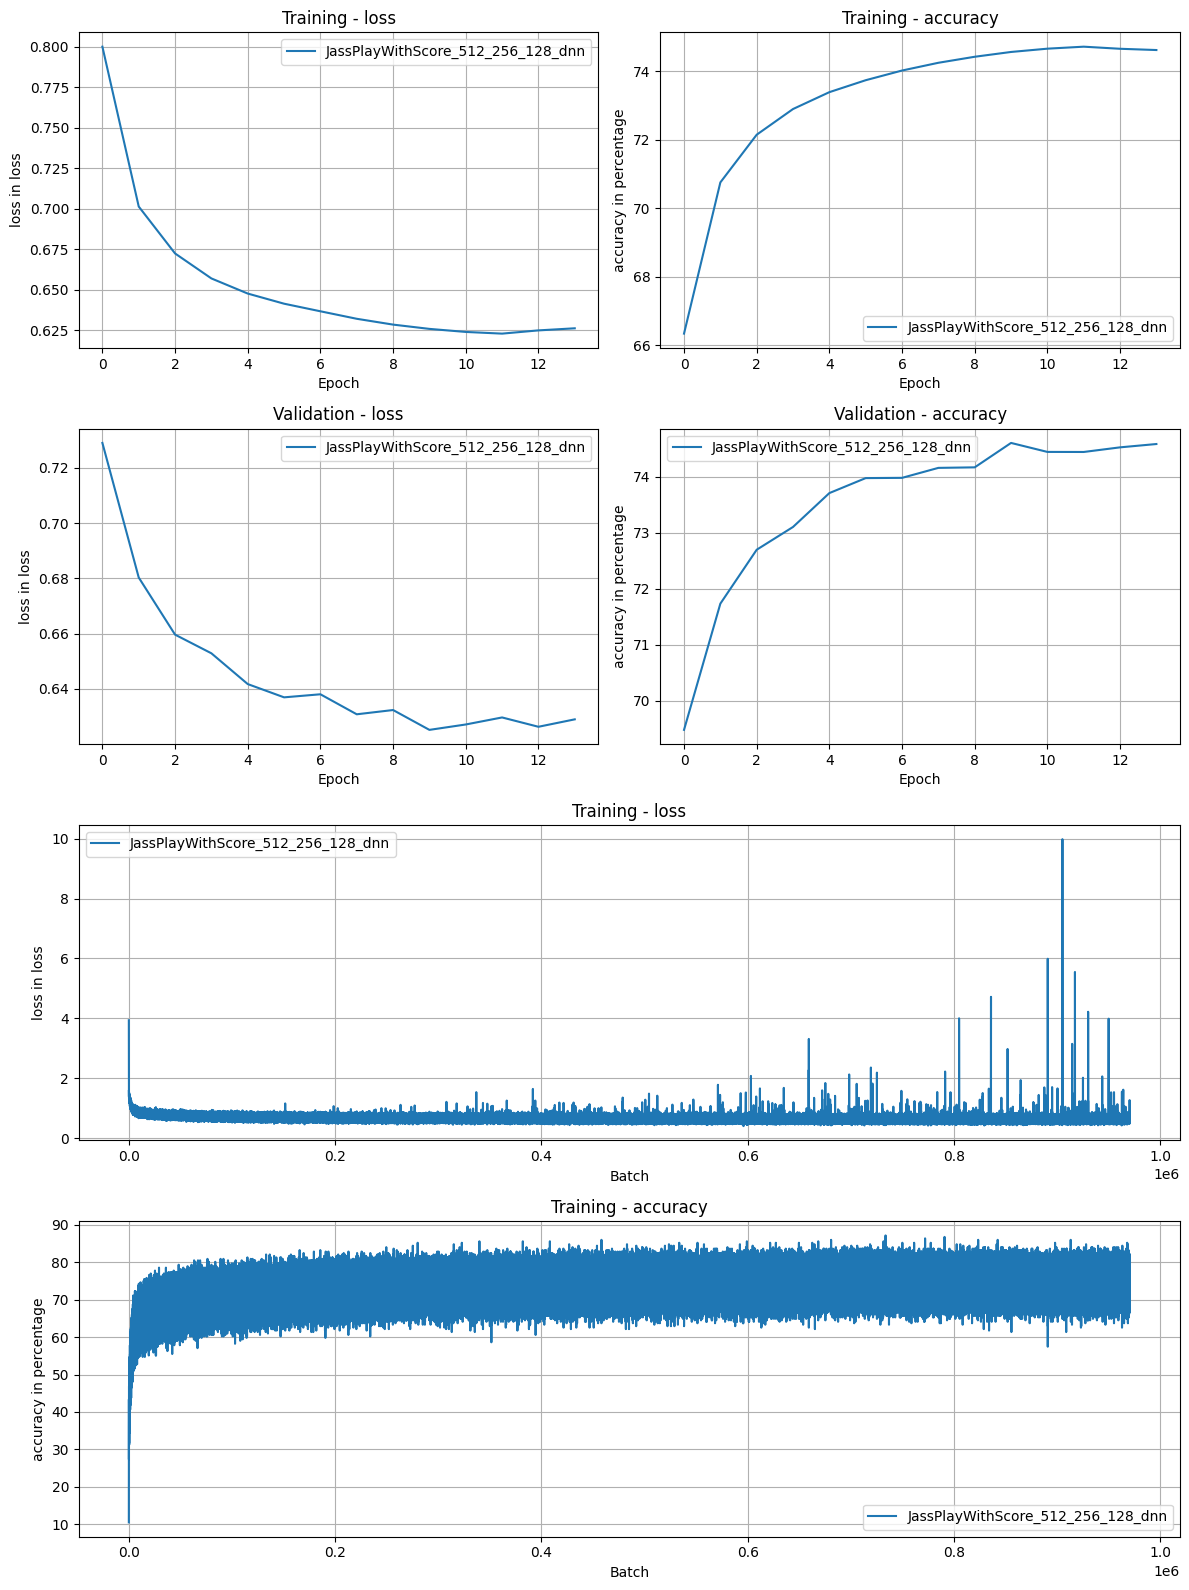

In [6]:
# create graphs
trainer.monitor.plot()

In [7]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [8]:
# export the model to ONNX
model = model.to("cpu")
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Error exporting model to ONNX: mat1 and mat2 shapes cannot be multiplied (1x924 and 937x512)
